## 自己定义一个网络结构
- 更新数据读取方式

In [1]:
# Import the necessary libraries
import numpy as np
import scipy
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import glob
%matplotlib inline
#from sklearn.cross_validation import StratifiedKFold

In [2]:
# Global Variables
BATCHSZ = 32
EPOCHS = 150

In [3]:
data_dir= "E:\Eric_HSI\hyper_data_preprocess\paviaU_w_size_9_num_200_for_2D"
data_root = glob.glob(data_dir + '/*')
print(data_root)

['E:\\Eric_HSI\\hyper_data_preprocess\\paviaU_w_size_9_num_200_for_2D\\data.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\paviaU_w_size_9_num_200_for_2D\\data_label.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\paviaU_w_size_9_num_200_for_2D\\test.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\paviaU_w_size_9_num_200_for_2D\\test_label.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\paviaU_w_size_9_num_200_for_2D\\train.npy', 'E:\\Eric_HSI\\hyper_data_preprocess\\paviaU_w_size_9_num_200_for_2D\\train_label.npy']


In [4]:
for name in glob.glob(data_dir + '/*'):
    print(name)

E:\Eric_HSI\hyper_data_preprocess\paviaU_w_size_9_num_200_for_2D\data.npy
E:\Eric_HSI\hyper_data_preprocess\paviaU_w_size_9_num_200_for_2D\data_label.npy
E:\Eric_HSI\hyper_data_preprocess\paviaU_w_size_9_num_200_for_2D\test.npy
E:\Eric_HSI\hyper_data_preprocess\paviaU_w_size_9_num_200_for_2D\test_label.npy
E:\Eric_HSI\hyper_data_preprocess\paviaU_w_size_9_num_200_for_2D\train.npy
E:\Eric_HSI\hyper_data_preprocess\paviaU_w_size_9_num_200_for_2D\train_label.npy


In [5]:
train = np.load(data_root[4])
train_label = np.load(data_root[5])
test = np.load(data_root[2])
test_label = np.load(data_root[3])
train.shape, train_label.shape, test.shape, test_label.shape

((1800, 9, 9, 103), (1800,), (40976, 9, 9, 103), (40976,))

In [6]:
# Reshape data into (numberofsumples, channels, height, width)

# convert class labels to on-hot encoding
train_label = utils.to_categorical(train_label)
test_label = utils.to_categorical(test_label)
train.shape, train_label.shape, test.shape, test_label.shape

((1800, 9, 9, 103), (1800, 9), (40976, 9, 9, 103), (40976, 9))

In [7]:
train.dtype, test.dtype, train_label.dtype, test_label.dtype

(dtype('float32'), dtype('float32'), dtype('float32'), dtype('float32'))

In [8]:
db_train = tf.data.Dataset.from_tensor_slices((train, train_label))
db_test = tf.data.Dataset.from_tensor_slices((test, test_label))

db_train = db_train.shuffle(train.shape[0]).repeat().batch(batch_size=BATCHSZ)
db_test = db_test.batch(batch_size=BATCHSZ)

In [9]:
db_train, db_test

(<BatchDataset shapes: ((None, 9, 9, 103), (None, 9)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 9, 9, 103), (None, 9)), types: (tf.float32, tf.float32)>)

In [10]:
# Define the model structure
model = tf.keras.models.Sequential()

# filters, kernels（一般小于7）， strides 默认为1， padding 默认为valid
# model.add(Conv2D(204, (1, 1), activation='relu', use_bias=False, input_shape=train[0].shape))
model.add(Conv2D(103, (1, 1), activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Conv2D(64, (1, 1), activation='relu', use_bias=False))
model.add(BatchNormalization())

# 9 * 9 * 204 -> 21 *21 * 204
model.add(tf.keras.layers.Conv2DTranspose(64, 3, 1,'valid', use_bias=False))
model.add(tf.keras.layers.LeakyReLU())
model.add(BatchNormalization())

# 21 * 21 * 204 -> 43 * 43 * 102
model.add(tf.keras.layers.Conv2DTranspose(32, 3, 1, 'valid', use_bias=False))
model.add(tf.keras.layers.LeakyReLU())
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', use_bias=False))
model.add(BatchNormalization())


model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

In [11]:
model.build(input_shape=(None, 9, 9, 103))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 103)         10609     
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 103)         412       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          6592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 19, 19, 64)        36864     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 19, 19, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 19, 19, 64)        2

In [12]:
if not os.path.exists('model_pavia'):
    os.mkdir('model_pavia')

In [13]:
# Define optimization and train method
# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1)
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./model_pavia/pavia3.h5',
                                                save_best_only=True,
                                                # save_weights_only=True,
                                                monitor='val_loss')]
# checkpointer = ModelCheckpoint(filepath=".\checkP\.checkpoint.ckpt", verbose=1, save_best_only=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [14]:
BATCHSZ = 32
EPOCHS = 200

In [15]:
# Start to train model 
history = model.fit(db_train,
                    batch_size=BATCHSZ, 
                    steps_per_epoch=train.shape[0]//BATCHSZ,
                    epochs=EPOCHS, 
                    validation_data=db_test, 
                    validation_steps=test.shape[0]//BATCHSZ,
                    callbacks=[reduce_lr, callbacks])

==] - 10s 174ms/step - loss: 0.0321 - acc: 0.9911 - val_loss: 0.1776 - val_acc: 0.9674
Epoch 63/200
56/56 [==============================] - 10s 174ms/step - loss: 0.0492 - acc: 0.9838 - val_loss: 0.0874 - val_acc: 0.9710
Epoch 64/200
56/56 [==============================] - 10s 173ms/step - loss: 0.0302 - acc: 0.9911 - val_loss: 0.1641 - val_acc: 0.9552
Epoch 65/200
56/56 [==============================] - 10s 174ms/step - loss: 0.0277 - acc: 0.9911 - val_loss: 0.0423 - val_acc: 0.9888
Epoch 66/200
56/56 [==============================] - 10s 172ms/step - loss: 0.0308 - acc: 0.9911 - val_loss: 0.0600 - val_acc: 0.9781
Epoch 67/200
56/56 [==============================] - 10s 170ms/step - loss: 0.0299 - acc: 0.9888 - val_loss: 0.0648 - val_acc: 0.9779
Epoch 68/200
56/56 [==============================] - 10s 172ms/step - loss: 0.0511 - acc: 0.9855 - val_loss: 1.4269 - val_acc: 0.7716
Epoch 69/200
54/56 [===========================>..] - ETA: 0s - loss: 0.0386 - acc: 0.9867
Epoch 00069:

In [16]:
model.build(input_shape=(None, 9, 9, 103))
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
# model.summary()
model.load_weights('./model_pavia/pavia3.h5')
model.evaluate(test, test_label, batch_size=32)

1281/1281 [==============================] - 8s 6ms/step - loss: 0.0086 - acc: 0.9974


[0.008649379946291447, 0.9974130988121033]

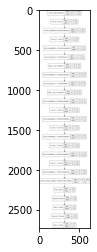

In [17]:
# using plot_model module to save the model figure
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./weights_pavia/model.png', show_shapes=True)
# show the model figure
model_img = plt.imread('./weights_pavia/model.png')
# plt.figure(dpi=180)
plt.imshow(model_img)
plt.show()

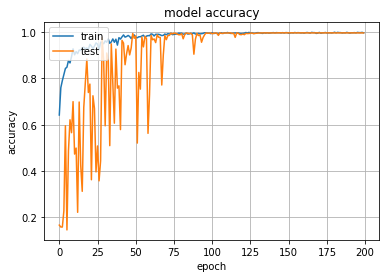

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
# plt.savefig("./result/model_accuracy_100.svg")
plt.show()

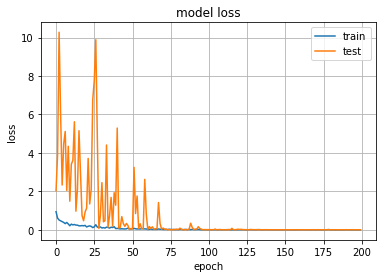

In [19]:
# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper right') 
# plt.savefig("./result/model_loss_100.svg")
plt.show()